# Photometric error

In [1]:
import sys, os
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from matplotlib.backends.backend_pdf import PdfPages


from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def valid_hp(cat, nside = 4096):
    
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=nside, nest= False)
    hpind_reject = hpRaDecToHEALPixel(cat['RA'][cat['VETO_FLAG'] == 0], 
                                    cat['DEC'][cat['VETO_FLAG'] == 0], nside=nside, nest= False)
    
    hppixnumber = np.arange(hp.nside2npix(nside))
    
    geomask = np.in1d( hppixnumber, hpind )
    rejectmask = np.in1d( hppixnumber, hpind_reject )
    
    print np.sum(geomask), np.sum(~rejectmask)
    
    
    totalmask = geomask * (~rejectmask)
    return hppixnumber[totalmask]


def hp_mask(cat, valid_hpind, nside = 4096):
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=nside, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    return HPmask




def callingBOSSmask(option='SGC'):
    
    if option == 'SGC':
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = fitsio.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')

    CleanMask = np.zeros((valid_hpind.size, ), dtype=[('PIXEL', 'i4'),('RA', 'f8'), ('DEC', 'f8')])
    CleanMask['PIXEL'] = valid_hpind
    sys_ra, sys_dec = hpHEALPixelToRaDec(valid_hpind, nside = 4096)
    CleanMask['RA'] = sys_ra
    CleanMask['DEC'] = sys_dec
    return CleanMask


def BOSSvetoing(cat, option='SGC'):
    
    if option == 'SGC':
        valid_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits')
    elif option == 'NGC': 
        valid_hpind = esutil.io.read('/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits')
    elif option =='all':
        valid_hpind = esutil.io.read(['/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12NGC-COMPSAM_V6C.fits',
                                   '/n/des/lee.5922/data/cmass_cat/vetomask/mask_nside4096_Patchy-Mocks-Randoms-DR12SGC-COMPSAM_V6C.fits'],
                                 combine=True)
    hpind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside=4096, nest= False)
    HPmask = np.in1d(hpind, valid_hpind)
    
    return cat[HPmask]

#valid_hp4096 = valid_hp(mock_rand_ngc, nside = 4096)
#vetoed_obj = hp_mask(mock_rand_ngc, valid_hp4096, nside = 4096)
#print 'vetoed by flag', np.sum(mock_rand_ngc['VETO_FLAG'] == 0)
#print 'vetoed by 4096mask', mock_rand_ngc.size - np.sum(vetoed_obj)
#print 'vetoed by 2048mask', mock_rand_sgc.size - np.sum(vetoed_obj2048)

In [18]:

rootdir = '../output/sfd_train_photo_SamPle_nozband_ran10_3_full_tol1e5/'
dmass_spt = io.SearchAndCallFits(path = rootdir, columns = None, keyword = 'dmass_spt_sys_v3.fits')
dmass_spt = dmass_spt[ dmass_spt['CMASS_PROB'] > 0.01 ]
dmass_st82 = io.SearchAndCallFits(path = rootdir, columns = None, keyword = 'gold_st82_prob.fits')
dmass_st82 =dmass_st82[ dmass_st82['EachProb_CMASS'] > 0.01]

train = esutil.io.read(rootdir+'train_sample_des.fits')
train = Cuts.keepGoodRegion(train)

train_cmass = esutil.io.read(rootdir+'train_sample_sdss.fits')
train_cmass = Cuts.keepGoodRegion(train_cmass)

dmass_spt = Cuts.keepGoodRegion(dmass_spt)
dmass_st82 = Cuts.keepGoodRegion(dmass_st82)

print np.sum(dmass_st82['EachProb_CMASS'])
print np.sum(dmass_spt['CMASS_PROB'])
print train.size


--------------------------------
 calling catalog
--------------------------------
dmass_spt_sys_v3.fits

--------------------------------
 calling catalog
--------------------------------
gold_st82_prob.fits
12637.112833275674
117292.90214602613
12639


In [54]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = np.sum(GoldMask_spt['FRAC']) #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  np.sum(GoldMask_st82['FRAC']) # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

print SPTMaparea, ST82Maparea

1243.5360337558907 123.17511816060514


In [7]:
from run_systematics import sys_iteration, fitting_SP, sys_ngal, weightmultiply, fitting_allSP, calling_sysMap, maskingCatalogSP

sysMap = calling_sysMap( properties=['FWHM'], kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/seeing_i_spt/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_FWHM_MEAN_coaddweights3_mean.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT


In [24]:
sys_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)
map_mask = np.in1d( GoldMask_spt['PIXEL'],  sysMap['sys_FWHM_r_SPT']['PIXEL'][sys_mask])
GoldMask_spt_sysmasked = GoldMask_spt[map_mask]
sptnpix_sys = np.sum(GoldMask_spt_sysmasked['FRAC']) 
#print np.sum(sys_mask), np.sum(map_mask)
#print GoldMask_spt.size, GoldMask_spt_sysmasked.size
SPTMaparea_sys = pixarea * sptnpix_sys
print SPTMaparea_sys, SPTMaparea

1218.6081762218325 1243.5360337558907


In [5]:

#hpix_dmass = hpRaDecToHEALPixel(dmass_spt['RA'], dmass_spt['DEC'], nside=4096, nest= False)
#dmass_spt_hpix = appendColumn(dmass_spt, name = 'PIXEL', value = hpix_dmass, dtypes=None)

In [32]:
import pandas as pd
desData = pd.DataFrame(dmass_spt)
goldData = pd.DataFrame(GoldMask_spt)
matched = pd.merge(desData, goldData, left_on='HPIX', right_on='PIXEL', how='left')
matched_arr = matched.to_records(index=False)

In [33]:
from utils import mergeCatalogsUsingPandas
dmass_spt_hpix = mergeCatalogsUsingPandas(des=dmass_spt, gold=GoldMask_spt, how = 'right', 
                                      left_key='HPIX', right_key = 'PIXEL', suffixes = ['','_GOLD'], 
                                      left_index=False, right_index = False)

In [34]:
BOSSCleanMaskSGC = callingBOSSmask(option='SGC')
BOSSCleanMaskNGC = callingBOSSmask(option='NGC')
BOSSSGCMaparea = BOSSCleanMaskSGC.size * pixarea
BOSSNGCMaparea = BOSSCleanMaskNGC.size * pixarea
print BOSSSGCMaparea, BOSSNGCMaparea

2422.648564262496 6523.511490618644


In [8]:
import numpy as np

path = '/n/des/lee.5922/data/cmass_cat/'
cmass_sgc = esutil.io.read(path+'galaxy_DR11v1_CMASS_South-photoObj.fits.gz')

#cmass_ngc = esutil.io.read(path+'galaxy_DR12v5_CMASS_North.fits.gz')
#cmass_sgc = esutil.io.read(path+'galaxy_DR12v5_CMASS_South.fits.gz')
#cmass_ngc = esutil.io.read(path+'cmass-dr12v4-N-Reid-full.dat.fits')
#cmass_sgc = esutil.io.read(path+'cmass-dr12v4-S-Reid-full.dat.fits')
#cmass_ngc = cmass_ngc[(cmass_ngc['Z'] > 0.43) & (cmass_ngc['Z'] < 0.7)]
#cmass_sgc = cmass_sgc[(cmass_sgc['Z'] > 0.43) & (cmass_sgc['Z'] < 0.7)]
#cmass_train = Cuts.SpatialCuts(cmass_sgc, ra=310, ra2=360, dec=-2, dec2=2)
cmass_train = Cuts.keepGoodRegion(cmass_sgc)

In [27]:
cmass = np.hstack([cmass_ngc, cmass_sgc])

In [49]:
gr_sgc_err = np.sqrt(cmass_sgc['MODELMAGERR'][:,1]**2 + cmass_sgc['MODELMAGERR'][:,2]**2)
ri_sgc_err = np.sqrt(cmass_sgc['MODELMAGERR'][:,2]**2 + cmass_sgc['MODELMAGERR'][:,3]**2)

gr_cmass_err = np.sqrt(cmass_train['MODELMAGERR'][:,1]**2 + cmass_train['MODELMAGERR'][:,2]**2)
ri_cmass_err = np.sqrt(cmass_train['MODELMAGERR'][:,2]**2 + cmass_train['MODELMAGERR'][:,3]**2)

gr_dmass_err = np.sqrt(train['MAGERR_DETMODEL_G']**2 + train['MAGERR_DETMODEL_R']**2)
ri_dmass_err = np.sqrt(train['MAGERR_DETMODEL_R']**2 + train['MAGERR_DETMODEL_I']**2)

In [38]:
np.sqrt( train['MAGERR_DETMODEL_G']**2+train['MAGERR_DETMODEL_R']**2 )

array([0.0440805 , 0.04523052, 0.05753129, ..., 0.03300682, 0.03931933,
       0.05322903], dtype=float32)

0.1940159 0.20088947 0.04520512
0.0708217 0.07530501 0.0128009925


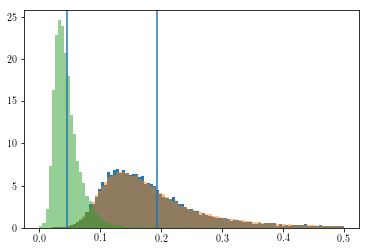

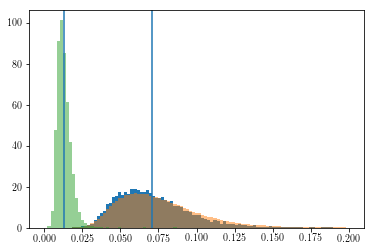

In [53]:
grbin = np.linspace(0, 0.5, 100)
fig, ax = plt.subplots()
ax.hist( gr_cmass_err, bins=grbin, normed=1 )
ax.hist( gr_sgc_err, bins = grbin, alpha = 0.5, normed=1)
ax.hist( gr_dmass_err, bins = grbin, alpha = 0.5, normed=1)
ax.axvline( x = np.mean(gr_cmass_err))
ax.axvline( x = np.mean(gr_dmass_err))
print np.mean(gr_cmass_err), np.mean(gr_sgc_err),np.mean(gr_dmass_err)

ribin = np.linspace(0, 0.2, 100)
fig, ax = plt.subplots()
ax.hist( ri_cmass_err, bins=ribin, normed=1 )
ax.hist( ri_sgc_err, bins = ribin, alpha = 0.5, normed=1)
ax.hist( ri_dmass_err, bins = ribin, alpha = 0.5, normed=1)
ax.axvline( x = np.mean(ri_cmass_err))
ax.axvline( x = np.mean(ri_dmass_err))
print np.mean(ri_cmass_err),np.mean(ri_sgc_err), np.mean(ri_dmass_err)

In [ ]:
gr_dmass_err = np.sqrt(cmass_train['MODELMAGERR'][:,1]**2 + cmass_train['MODELMAGERR'][:,2]**2)
ri_dmass_err = np.sqrt(cmass_train['MODELMAGERR'][:,2]**2 + cmass_train['MODELMAGERR'][:,3]**2)